# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design T cells that respond to diseases like cancer.

In [366]:
## Import the libraries 

import matplotlib.pyplot as plt
import numpy as np
import scipy 
from scipy.optimize import least_squares

Stone et al: 
Goal: A model to predict activation and binding behavior for T cells and MHC aligomers with differenet properties. 
Kd constant ( units of molarity )- characterization of monovalent binding of a ligand to its receptor 
Kx ( units of (#cells)-1) : cross-linking constant 
independet modeling parameter is k (lower case) which is the unitless product of the receptor density (Rtot/A)
2D equilibrium binding constant (Kx*A)
Rtot : is the total receptor number
v: is the number of oligomer of valeny 
R bound = Rtot-Req



In [367]:

# Raise an error when an overflow occurs 
np.seterr(over='raise')


{'divide': 'warn', 'over': 'raise', 'under': 'ignore', 'invalid': 'warn'}

In [368]:


# Req_Function
# Number of Photoreceptors 
def Req_func(Phisum, Rtot, L0, KxStar, f, Ka):
    """ Mass balance. Transformation to account for bounds. """
    Req = Rtot / (1.0 + L0 * f * Ka * (1 + Phisum) ** (f - 1))
    return Phisum - Ka * KxStar * Req




## Model that returns LBound, Rbnd, RMulti 
# StoneMod
# Input: Rtot, Kd,v, Kx, L0

def StoneMod(Rtot: float, Kd: float, v, Kx: float, L0: np.ndarray):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    # print(f'StoneMod {Kx}')
    v = np.int_(v)
    assert L0.shape == v.shape

    if Rtot <= 0.0:
        raise RuntimeError("You input a negative amount of receptor.")
    
    if Kx <= 0.0:
        raise RuntimeError("You input a negative Kx.")

    if np.amin(L0) <= 0.0:
        raise RuntimeError("You input a negative L0.")

    Ka = 1.0 / Kd
    KxStar = Kx / Ka

    ## Solve Req by calling least_squares
    lsq = least_squares(Req_func, np.ones_like(L0), jac="cs",
                        max_nfev=5000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        args=(Rtot, L0, KxStar, v, Ka))

    if lsq['success'] is False:
        print(lsq)
        raise RuntimeError("Failure in solving for Req. If you see this message contact Dr. Meyer.")

    Phisum = lsq.x

    # Calculate L, according to equation 7
    Lbound = L0 / KxStar * ((1 + Phisum) ** v - 1)

    # Calculate Rmulti from equation 5
    Rmulti = L0 / KxStar * v * Phisum * ((1 + Phisum) ** (v - 1) - 1)

    # Calculate Rbound
    Rbnd = L0 / KxStar * v * Phisum * (1 + Phisum) ** (v - 1)

    return Lbound, Rbnd, Rmulti



In [369]:
# Experimental Data
# FIGURE 3 Comparison of experimental CD3 downregulation data and model predictions. 
#The predicted sum of multivalently bound oligomers at each concentration was fit to experimental CD3 downregulation 
#data for treatment with a dimer (), trimer (Œ), and tetramer (f) (Cochran et al., 2000).
# (B) The response at 27 h of incubation with the oligomers. Best fit parameters shown in Table 1.

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)




#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

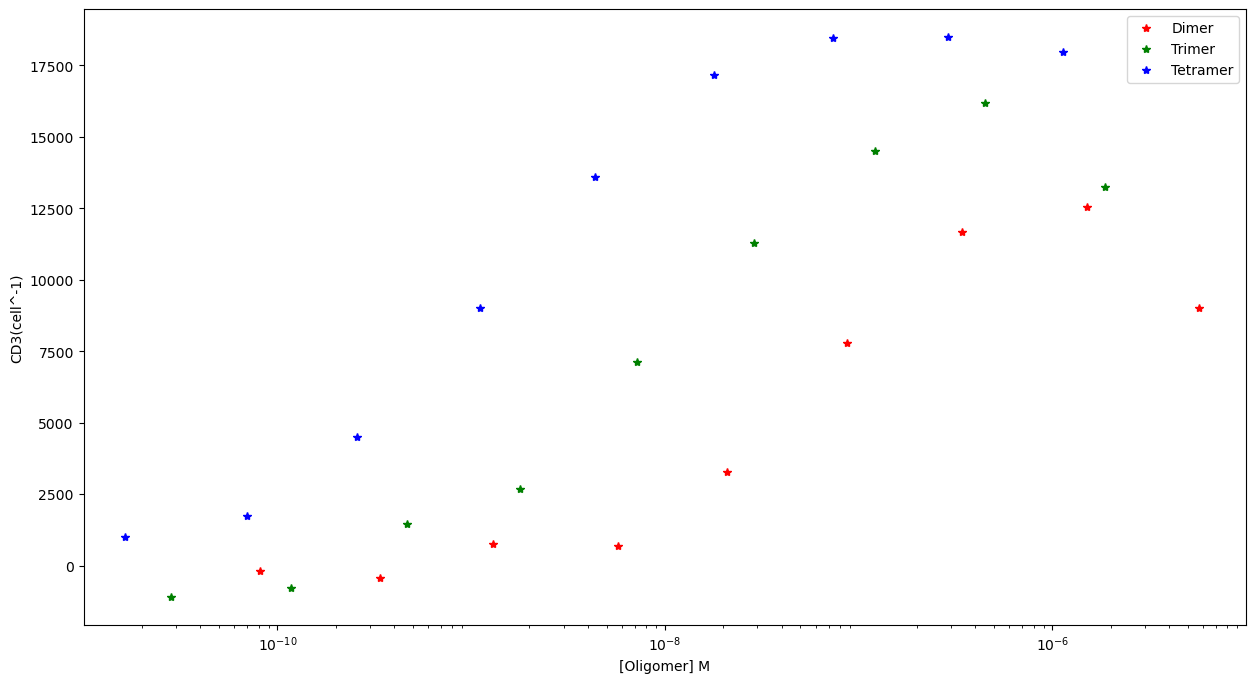

In [357]:
# Note that Xs are the concentrations from the experiment
# Vs are the complex valencies
# Ys are the measurements of response
# Each of these vectors is the same length, with each position describing an experimental measurement

# Note that Xs are the concentrations from the experiment
# Vs are the complex valencies
# Ys are the measurements of response
# Each of these vectors is the same length, with each position describing an experimental measurement

def plot_valency_data(Xs_in, Ys_in, Vs_in, format='o-'):
    """If you pass in your real or simulated data, this will plot it for you."""
    colors = ['r', 'g', 'b']

    for valency in range(3):
        plt.semilogx(Xs_in[Vs_in == valency + 2], 
                     Ys_in[Vs_in == valency + 2],
                     colors[valency] + format)
            
    
    plt.xlim([1E-11, 1E-5])
    plt.xticks([1E-10, 1E-8, 1E-6])
    plt.xlabel('[Oligomer] M')
    plt.ylabel('CD3(cell^-1)')
    plt.legend(['Dimer','Trimer','Tetramer'])
    



# Plot this data
plt.figure(figsize=(15,8))
plot_valency_data(Xs,Ys,Vs,'*')

Describe the relationship you see between Kx, Kd, and valency? The valency shifts the peak towards left and increases the peak. Therefore, increasing valency increases the amount of multimerized receptor (max peak increases ) and decreases the concentration of oligomer (shifts towards left). 



#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

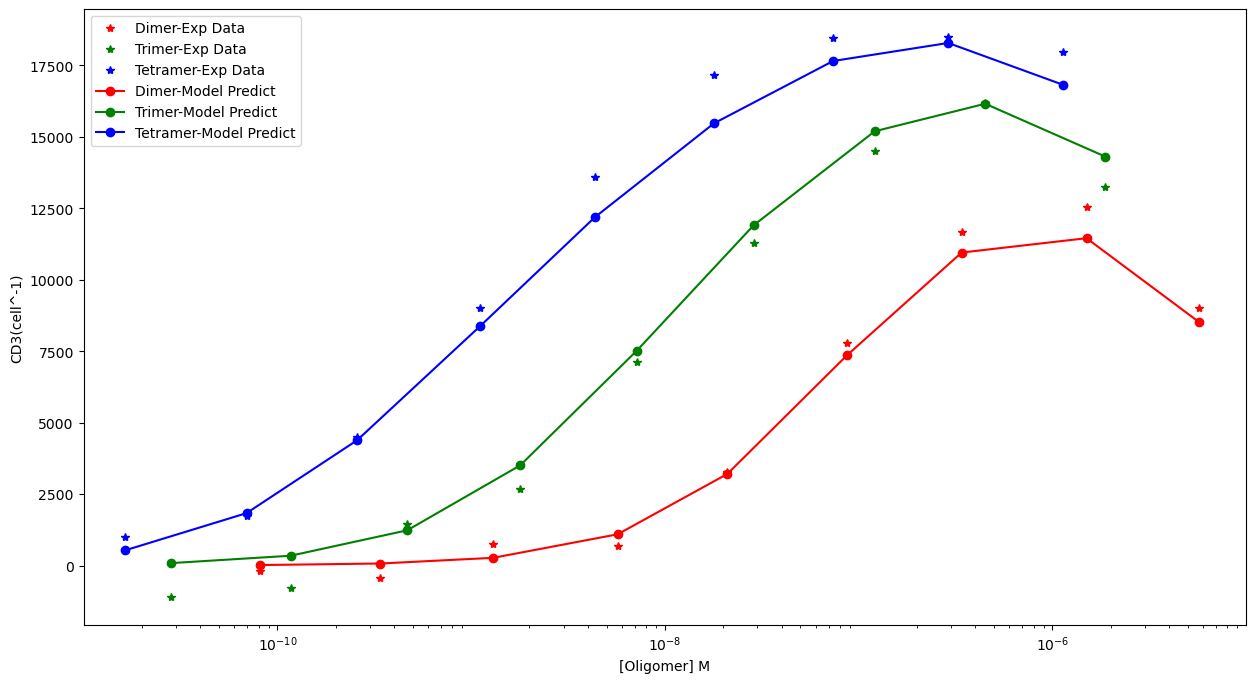

In [358]:
# Here is a scaling function
# Note that the unknown parameters are passed in as an array
# This will make working with least_squares() easier later

# Fit Parameters for CD3 ( after 27 hours) - scaling parameters  
scale=1
Kd=1.7e-6
Kx=3.15e-4
Rtot=24000
# Define a list for initial parameters 
parameters = [scale, Kd , Kx]

# scale and predict 
# Vs: Valency, Xs: Concentration of Oligomer 

def scale_StoneMod(parameters, Vs, Xs):
    # print(f'scale_stoneMod {parameters}')
    # input: Hyperparameters, valency and concentration of oligomer 
    # output: predicted Y
    Rtot = 24000.0 # cell^-1
    Lbound, Rbnd, Rmulti = StoneMod(Rtot, parameters[1], Vs, parameters[2], Xs)
    # scale factor is multiplied by RMulti
    return parameters[0] * Rmulti

# Answer
# Define a function that 1) takes the model predictions/ 2) sacle them to the units of the actual measurements/ 3) Find predictions for each condition 
# scale responses to the actual measurements and find predictions
scaled_model=scale_StoneMod(parameters,Vs,Xs)

plt.figure(figsize=(15,8))
# Actual Data 
plot_valency_data(Xs,Ys,Vs,'*')
# Predicted Data 
plot_valency_data(Xs,scaled_model,Vs)
plt.legend(['Dimer-Exp Data', 'Trimer-Exp Data', 'Tetramer-Exp Data', 'Dimer-Model Predict', 'Trimer-Model Predict', 'Tetramer-Model Predict'])

#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

[ -213.26201164  -508.08301865   490.55025317  -408.63781333
    73.98713987   449.20726674   719.74018423  1086.44151189
   489.90763861 -1189.45339733 -1112.80981733   221.19727793
  -811.01421033  -382.58593752  -614.36471133  -693.29758891
    33.30003823 -1071.78963965   453.86382918   -99.68527411
   106.72826476   646.16184121  1395.65658462  1691.75085001
   788.91199758   204.21913152  1145.60200193]
LSQ scale is 1.0281501642501838, LSQ kD is 1.702860554819845e-06, LSQ Kx is (0.0003147313497258523, 0.0003147313497258523)


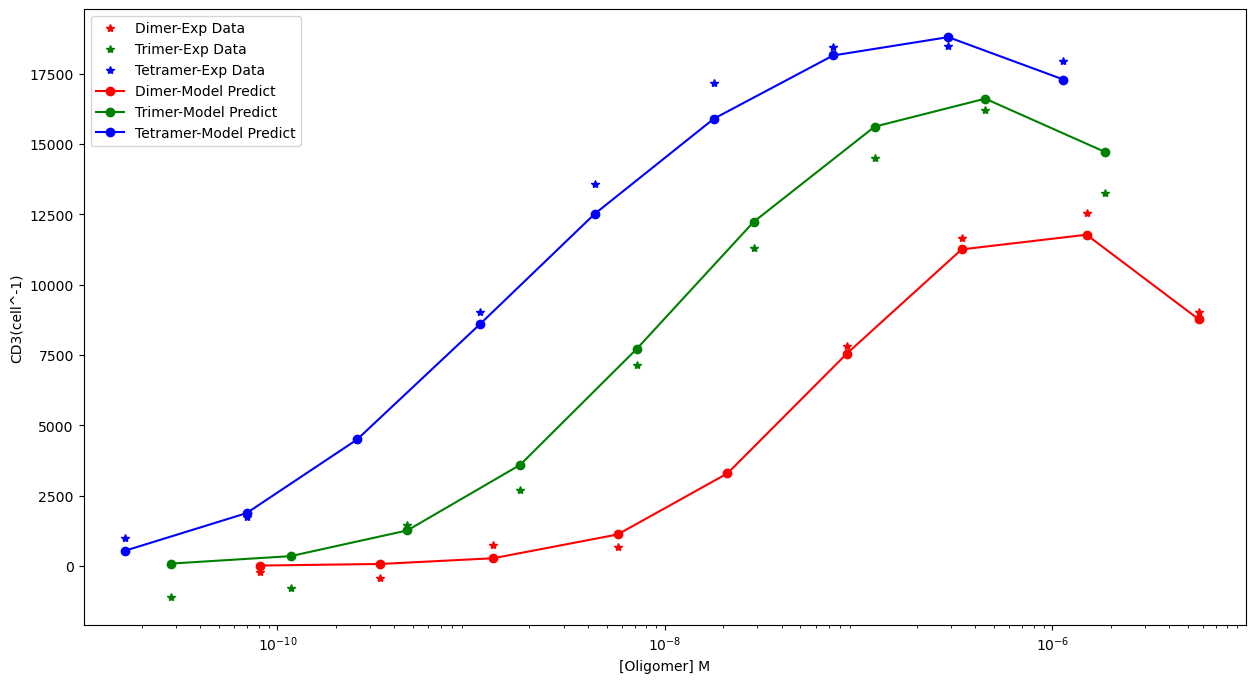

In [359]:
# You will need a function that returns the residuals ( diff between the actual data and predicted data)
def residuals(parameters, Vs_in, Xs_in, Ys_in):
    # return the difference between the actual Y and predicted Y * Y^ which is residuals 
    return Ys_in - scale_StoneMod(parameters, Vs_in, Xs_in)



# Note that the data (Xs, Ys) are not unknowns, so they should be passed in using the args argument of least_squares
scale=1
Kd=1.7e-6
Kx=3.15e-4
Rtot=24000

parameters = [scale, Kd , Kx]
res_params=residuals(parameters,Vs,Xs,Ys)
print(res_params)


# With this function, your least squares call should look something like this:
lsq_parameters = scipy.optimize.least_squares(residuals, parameters, args=(Vs, Xs, Ys))


lsq_scale=lsq_parameters.x[0]
lsq_kd=lsq_parameters.x[1]
lsq_kx=lsq_parameters.x[2]
lsq_params=[lsq_scale,lsq_kd,lsq_kx]

print(f'LSQ scale is {lsq_scale}, LSQ kD is {lsq_kd}, LSQ Kx is {lsq_kx,lsq_kx}')

# Predict
scaled_model=scale_StoneMod(lsq_params,Vs,Xs)

plt.figure(figsize=(15,8))
plot_valency_data(Xs,Ys,Vs,'*')
plot_valency_data(Xs,scaled_model,Vs)
plt.legend(['Dimer-Exp Data', 'Trimer-Exp Data', 'Tetramer-Exp Data', 'Dimer-Model Predict', 'Trimer-Model Predict', 'Tetramer-Model Predict'])

#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

(27,)
(27,)
(27,)


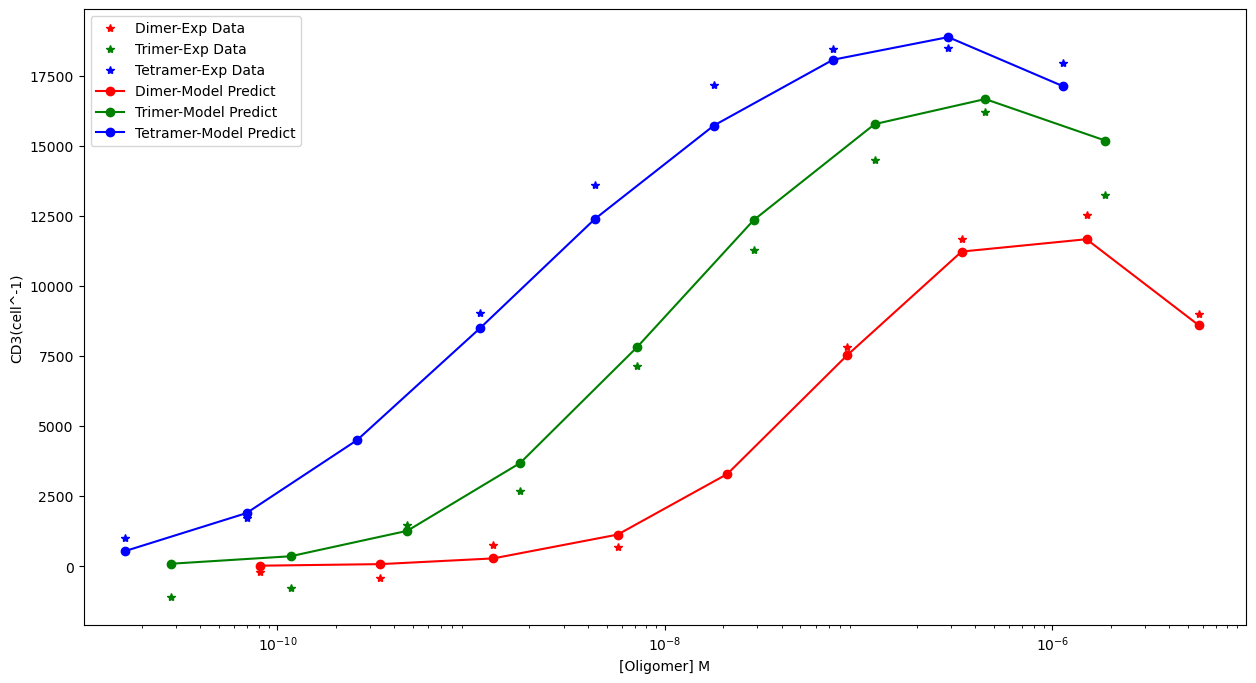

In [360]:
# scikit-learn provides a great interface for getting indices that help you split the data
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
# Leave one out k= N and we just leave one sample out 

# Initial values 
scale=1
Kd=1.7e-6
Kx=3.15e-4
Rtot=24000
parameters = [scale, Kd , Kx]



# Cross Validation 
# Xs are the concentrations from the experiment
X_c=np.empty_like(Xs)
print(X_c.shape)
# Vs are the complex valencies
V_c=np.empty_like(Vs)
print(V_c.shape)
# Ys are the measurements of response
Y_pred=np.empty_like(Ys)
# Y Data 
print(Y_pred.shape)



## create an empty list and go through the for loop/ remember indices
for train_idx, test_idx in LeaveOneOut().split(Vs):
    
    # Vs are the complex valencies: 2,3,4
    # one is for test [2] and the rest [0,1,3,4]
    Vs_training = Vs[train_idx]
    Vs_testing = Vs[test_idx]
    #print(Vs_training,Vs_testing)
    
    # Xs are the concentrations from the experiment
    # one is for test [2] and the rest [0,1,3,4]
    Xs_training=Xs[train_idx]
    Xs_testing=Xs[test_idx]
    #print(Xs_training,Xs_testing)

    # Ys are the measurements of response
    # one is for test [2] and the rest [0,1,3,4]
    Ys_training=Ys[train_idx]
    Ys_testing=Ys[test_idx]
    #print(Ys_training,Ys_testing)
    

    # With this function, your least squares call should look something like this:
    
    lsq_parameters = scipy.optimize.least_squares(residuals, parameters, args=(Vs_training, Xs_training, Ys_training))
    
    lsq_scale=lsq_parameters.x[0]
    lsq_kd=lsq_parameters.x[1]
    lsq_kx=lsq_parameters.x[2]
    lsq_params=[lsq_scale,lsq_kd,lsq_kx]
    

    
    # Prediction
    scaled_model=scale_StoneMod(lsq_params,Vs_testing,Xs_testing)
    X_c[test_idx]=Xs_testing[0]
    V_c[test_idx]=Vs_testing[0]
    Y_pred[test_idx]=scaled_model[0]
    
    
    
##Plot the measured vs prediction   

plt.figure(figsize=(15,8))
plot_valency_data(Xs,Ys,Vs,'*')
plot_valency_data(X_c,Y_pred,V_c)
plt.legend(['Dimer-Exp Data', 'Trimer-Exp Data', 'Tetramer-Exp Data', 'Dimer-Model Predict', 'Trimer-Model Predict', 'Tetramer-Model Predict'])



In [361]:
R2=r2_score(Ys,Y_pred)
print(f'R2 is {R2}')

R2 is 0.9853101569618764


Does this model predict the data? Yes, the model effectively predicts the data and it follows the same trends as the experimental data. To evaluate the model prediction, R2 was found between the actual data and predicted data. R-squared value is 0.985 which implies that 98.53% of the variability in the data is accounted in our model. 

#### (5) Using bootstrap estimation, plot the confidence interval of the model predictions along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

In [362]:
import pandas as pd
from sklearn.utils import resample

Rtot = 24000
Kd = 1.7E-6
Kx = 3.15E-4

# Number of Bootstraps
n_bootstraps = 100
scale = 1
params_guess = [scale, Kd, Kx]

# Use half of the data 
n_samples = len(Xs) // 2
boot_pred = pd.DataFrame(index=range(n_bootstraps), columns=range(len(Xs)))

for boot_index in range(n_bootstraps):
    # Only train data 
    X_train, Y_train, V_train = resample(Xs, Ys, Vs, replace=True, n_samples=n_samples)
    # Find least square error with train data 
    lsq_params = least_squares(residuals, params_guess, args=(V_train, X_train, Y_train))
    lsq_scale = lsq_params.x[0]
    lsq_kd = lsq_params.x[1]
    lsq_kx = lsq_params.x[2]
    param_lsq=[lsq_scale,lsq_kd ,lsq_kx ]
    
    # Predict the output for each bootstrap ( using Vs and Xs)
    prediction = scale_StoneMod(param_lsq,Vs,Xs)
    boot_pred.loc[boot_index, :] = prediction


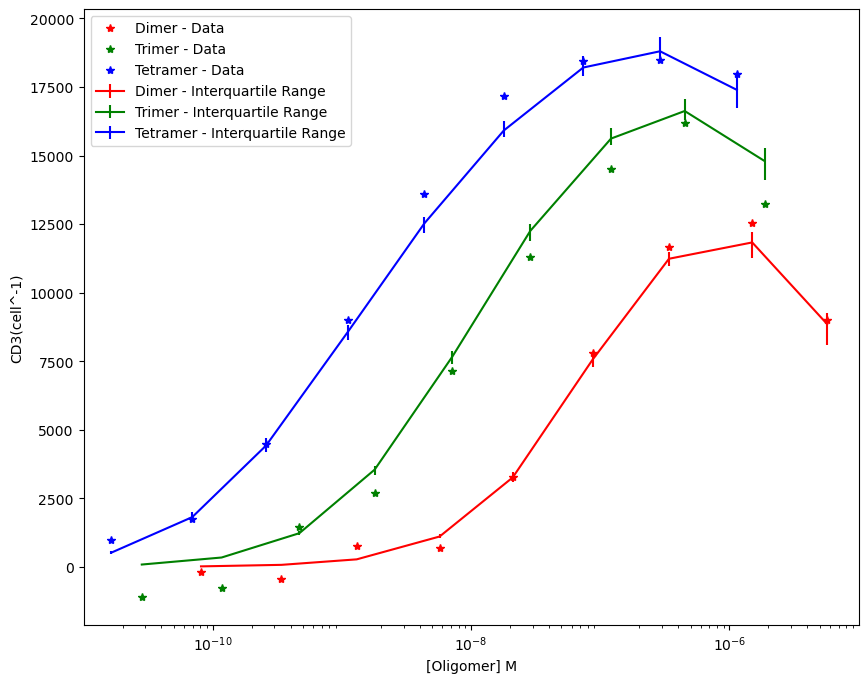

In [363]:
# "Confidence interval" does not have a precise definition. 
#For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).


medians = boot_pred.apply(np.percentile, args=(50,))
p_75 = boot_pred.apply(np.percentile, args=(75,))
p_25 = boot_pred.apply(np.percentile, args=(25,))
error_bars = pd.DataFrame([medians - p_25, p_75 - medians])

colors = ['r', 'g', 'b']
plt.figure(figsize=(10, 8))
plot_valency_data(Xs, Ys, Vs,'*')



for i in range(3):
    plt.errorbar(Xs[9*i:9*(i+1)], medians.iloc[9*i:9*(i+1)], 
                 yerr=np.array(error_bars.iloc[:, 9*i:9*(i+1)]), 
                 color=colors[i])
    
plt.legend(['Dimer - Data', 'Trimer - Data', 'Tetramer - Data',
            'Dimer - Interquartile Range', 'Trimer - Interquartile Range',
            'Tetramer - Interquartile Range'])


#### (6) _Generally_, how would you expect the cross-validation and bootstrap results to change if you had fewer data points?

Explain your answer.

Having fewer data points leads to higher variability in model performance. In cross-validation, each fold would have less number of data points, so each fold may not represent the overal population well. In bootstrapping, the diversity in resamples would decreases with fewer data points. So bootstrap samples (which are drawn with replacement from the dataset ) might not represet the broader dataset. The probability that the fold doesn't have the data to effectively fit the curve would increase. Also, with small dataset, the possibility of overfitting would increase. 

#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down relative to its optimum by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter affects the error the most? Which one the least?

You should get a plot that roughly looks like a "U" for each parameter. Use a log-log plot to show the variation the best (`plt.loglog`).

In [364]:
# Initial values 
from sklearn.metrics import mean_squared_error

# Initial values 
scale=1
Kd=1.7e-6
Kx=3.15e-4
Rtot=24000


# different multiplication factor for the scale, Kx and Kd
param_mod=np.arange(0.1,15,0.5)

mse_scale=[]
mse_Kd=[]
mse_Kx=[]



for mod in param_mod:
    
    # scale 
    # Modify the parameters 
    parameters1 = [scale*mod, Kd , Kx]
    # Predict the output 
    predict= scale_StoneMod(parameters1,Vs,Xs)
    # Store the MSE values 
    mse_scale.append(mean_squared_error(predict,Ys))
    
    #Kd
    # Modify the parameters 
    parameters2 = [scale, Kd*mod , Kx]
    # Predict the output 
    predict2= scale_StoneMod(parameters2,Vs,Xs)
    # Store the MSE values 
    mse_Kd.append(mean_squared_error(predict2,Ys))    
    
    #Kx
    # Modify the parameters 
    parameters3= [scale, Kd , Kx*mod]
    # Predict the output 
    predict3= scale_StoneMod(parameters3,Vs,Xs)
    # Store the MSE values 
    mse_Kx.append(mean_squared_error(predict3,Ys))    
    

<Figure size 640x480 with 0 Axes>

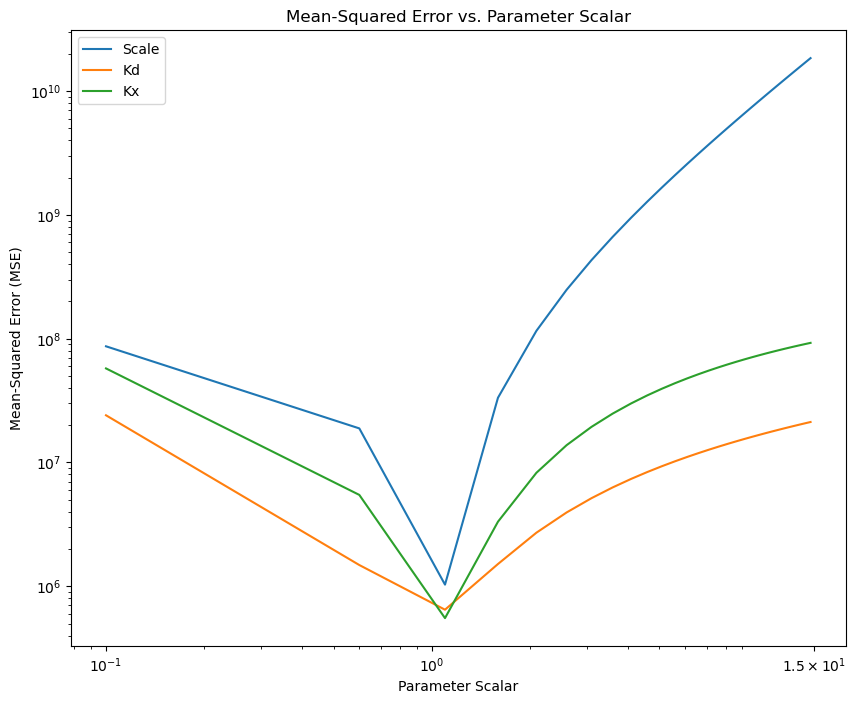

In [365]:
plt.figure()
plt.figure(figsize=(10,8))
plt.loglog(param_mod, mse_scale)
plt.loglog(param_mod, mse_Kd)
plt.loglog(param_mod, mse_Kx)
plt.ylabel('Mean-Squared Error (MSE)')
plt.xlabel('Parameter Scalar')
plt.xticks([.1, 1, 15])
plt.title('Mean-Squared Error vs. Parameter Scalar')
plt.legend(['Scale', 'Kd', 'Kx'])
plt.yscale('log')
plt.show()

As it can be seen, the scale parameter appears to have the greatest effect on the fit; modifying this parameter induces the largest MSE of the three tunable parameters. On the other hand, the Kd has less effect on the model fit, as changes to this parameter induce the least MSE of the three parameters.